In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import sqlite3 as sq
import matplotlib.pyplot as plt
%matplotlib inline

# Add extra relevant packages below as needed: 
import shutil
import numpy as np
import os
import re

In [2]:
# Import TMDB Database and format
db = pd.read_csv('zippedData/tmdb.movies.csv.gz')
db['genre_ids'].replace([''], np.nan, inplace=True)

#Import TN Database
tn_budget_raw = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#Combine TN and TMDB databases
result = pd.merge(tn_budget_raw, db, left_on='movie', right_on='original_title',how='inner')
result.drop(columns=['id_x','Unnamed: 0','genre_ids','id_y','original_title','title'], inplace=True)

# Unzip IMDB SQL to new folder repository
import zipfile
with zipfile.ZipFile("zippedData/im.db.zip", 'r') as zip_ref:
    zip_ref.extractall("temp/IMDB_sql")
    
db_file = 'temp/IMDB_sql/im.db'

# Initializing imdb SQL database
# Create a SQL connection to our SQLite database
con = sq.connect(db_file)


## Query database for relevant information
genre_reviews = pd.read_sql(""" SELECT genres, primary_title, start_year
                
                FROM movie_basics
                LEFT JOIN movie_ratings ON movie_ratings.movie_id = movie_basics.movie_id
                JOIN movie_akas ON movie_akas.movie_id = movie_basics.movie_id
                WHERE start_year >= 2015 and region = 'US'
                ORDER BY averagerating DESC

""", con)

# Remove NaN values from SQL database
genre_reviews.dropna(inplace = True)

# Combine CSV and SQL data and format
comb_data = pd.merge(result, genre_reviews, left_on='movie', right_on='primary_title',how='inner')
comb_data.drop(columns=['primary_title', 'release_date_x','release_date_y'], inplace=True)
comb_data.drop_duplicates(subset=['movie'], inplace=True, ignore_index=True)

# Convert production budgets into ints
comb_data['production_budget'] = comb_data['production_budget'].str.strip('$')
comb_data['production_budget'] = comb_data['production_budget'].str.replace(',','')
comb_data['production_budget'] = comb_data['production_budget'].astype(int)

#Convert domestic gross into ints
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.strip('$')
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.replace(',','')
comb_data['domestic_gross'] = comb_data['domestic_gross'].astype(int)

# Convert worldwide gross into ints
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.strip('$')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.replace(',','')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].astype(int)

# Removing movies that made less than $25,000
comb_data = comb_data[(comb_data['worldwide_gross'] > 25000)]

# Create movie net columns
comb_data['worldwide_net'] = comb_data['worldwide_gross'] - comb_data['production_budget']
comb_data['domestic_net'] = comb_data['domestic_gross'] - comb_data['production_budget']

# Sort by worldwide net
comb_data.sort_values(by="worldwide_net", ascending=False, inplace=True, ignore_index=True)

In [3]:
# Create new df with genre counts higher than n
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) > 10]

In [4]:
# Print master data frame
comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015,1328722794,163007020
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
...,...,...,...,...,...,...,...,...,...,...,...,...
585,Turbulence,55000000,11532774,11532774,en,1.073,5.6,5,"Action,Drama,Thriller",2016,-43467226,-43467226
586,Blackhat,70000000,8005980,19665004,en,16.824,5.3,1165,"Action,Crime,Thriller",2015,-50334996,-61994020
587,Monster Trucks,125000000,33370166,61642798,en,8.827,5.9,414,"Action,Adventure,Comedy",2016,-63357202,-91629834
588,Air Strike,65000000,0,516279,en,6.971,3.9,56,"Action,Adventure,Drama",2018,-64483721,-65000000


In [5]:
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) > 10]
df1['genres'].value_counts()

Drama                         33
Adventure,Animation,Comedy    32
Comedy                        25
Action,Adventure,Sci-Fi       21
Action,Adventure,Fantasy      19
Action,Crime,Drama            17
Horror,Mystery,Thriller       16
Horror,Thriller               15
Comedy,Drama                  14
Comedy,Drama,Romance          13
Documentary                   13
Biography,Drama,History       12
Action,Adventure,Comedy       11
Biography,Comedy,Drama        11
Name: genres, dtype: int64

In [6]:
df1

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
6,Minions,74000000,336045770,1160336173,en,9.338,6.4,7343,"Adventure,Animation,Comedy",2015,1086336173,262045770
...,...,...,...,...,...,...,...,...,...,...,...,...
580,The Lovers,35000000,0,53899,en,5.232,4.7,47,"Comedy,Drama,Romance",2017,-34946101,-35000000
582,Rock Dog,60000000,9420546,24148488,en,10.362,5.7,123,"Adventure,Animation,Comedy",2016,-35851512,-50579454
584,Live by Night,65000000,10378555,21774432,en,11.322,6.2,759,"Action,Crime,Drama",2016,-43225568,-54621445
587,Monster Trucks,125000000,33370166,61642798,en,8.827,5.9,414,"Action,Adventure,Comedy",2016,-63357202,-91629834


In [7]:
# Define a function to get the mean of any metric (column) by genre
def get_genre_avg(genre, metric):
    df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
    df2 = df1[(df1[genre+"_count"] == 1)]
    df2_avg = df2[metric].mean()
    df1.drop(columns=[genre+"_count"], inplace=True)
    return df2_avg

In [8]:
get_genre_avg('Drama','domestic_net')

<ipython-input-7-512658f3646a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
C:\Users\12676\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


11677754.61

In [9]:
def get_barplot(metric):
    x = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller']
    y = []
    for i in x:
        y.append(get_genre_avg(i, metric))

    plt.figure(figsize = (15,8))
    ax = sns.barplot(x, y)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90);
    return ax

<ipython-input-7-512658f3646a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
C:\Users\12676\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-7-512658f3646a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

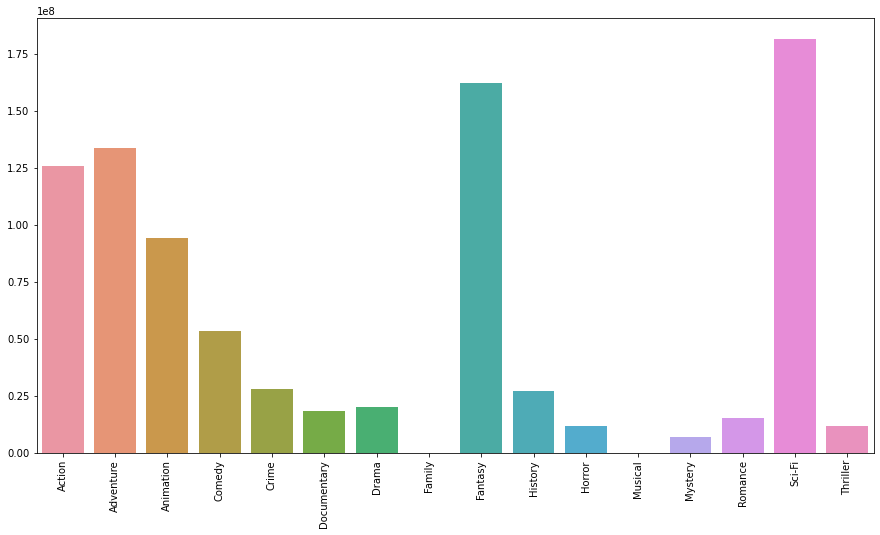

In [10]:
#movie	production_budget	domestic_gross	worldwide_gross	original_language	popularity	vote_average	vote_count	genres	start_year	worldwide_net	domestic_net
get_barplot("production_budget");

In [11]:
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) >= 15]

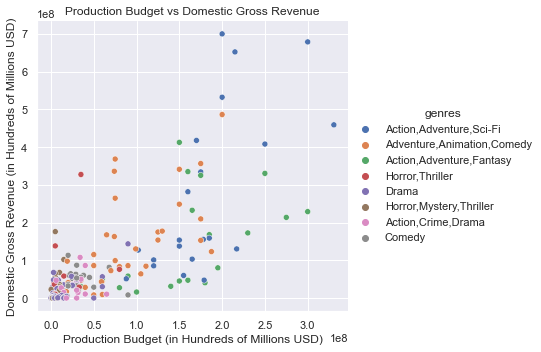

In [12]:
sns.set_theme(style='darkgrid')
pvd = sns.relplot(x=df1['production_budget'], y=df1['domestic_gross'], hue=df1['genres']).set(
    
    title="Production Budget vs Domestic Gross Revenue",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Domestic Gross Revenue (in Hundreds of Millions USD)",
    )


,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,vote_count,start_year,worldwide_net,domestic_net
production_budget,1.000000,0.701904,0.773897,0.576063,0.082629,0.609798,0.055277,0.663784,0.163462
domestic_gross,0.701904,1.000000,0.946660,0.505589,0.191072,0.684674,0.075827,0.942387,0.817426
worldwide_gross,0.773897,0.946660,1.000000,0.571057,0.189167,0.724207,0.077777,0.987369,0.685324
popularity,0.576063,0.505589,0.571057,1.000000,0.262210,0.678333,0.302575,0.530291,0.234401
vote_average,0.082629,0.191072,0.189167,0.262210,1.000000,0.324905,0.029276,0.202730,0.197825
vote_count,0.609798,0.684674,0.724207,0.678333,0.324905,1.000000,-0.031380,0.702717,0.455164
start_year,0.055277,0.075827,0.077777,0.302575,0.029276,-0.031380,1.000000,0.078024,0.060322
worldwide_net,0.663784,0.942387,0.987369,0.530291,0.202730,0.702717,0.078024,1.000000,0.768457
domestic_net,0.163462,0.817426,0.685324,0.234401,0.197825,0.455164,0.060322,0.768457,1.000000


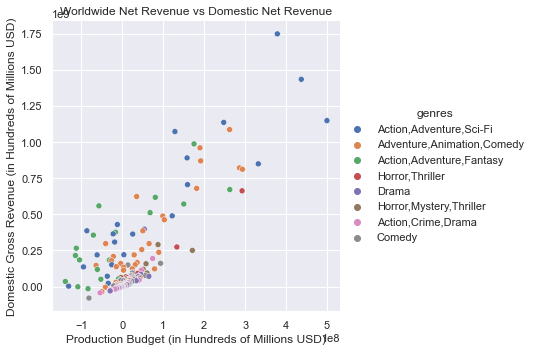

In [25]:

sns.set_theme(style='darkgrid')
dvw = sns.relplot(y=df1['worldwide_net'], x=df1['domestic_net'], hue=df1['genres'])
;

dvw.set(
    
    title="Worldwide Net Revenue vs Domestic Net Revenue",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Domestic Gross Revenue (in Hundreds of Millions USD)",
    )


comb_data.corr()

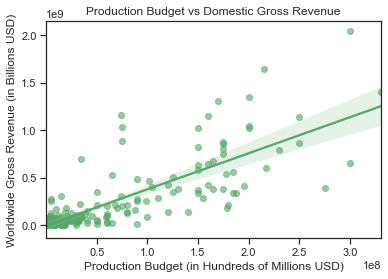

In [24]:

sns.set_style("ticks")
pvw = sns.regplot(x=df1['production_budget'], y=df1['worldwide_gross'], 
                  data=df1, scatter_kws={'alpha':0.6 },
                 color="g", )
pvw.set(
    
    title="Production Budget vs Domestic Gross Revenue",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Worldwide Gross Revenue (in Billions USD)",

    )
sns.set_style("whitegrid")

[Text(0.5, 1.0, 'Production Budget vs Popularity'),
 Text(0.5, 0, 'Production Budget (in Hundreds of Millions USD)'),
 Text(0, 0.5, 'Popularity')]

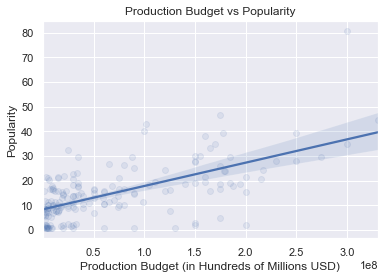

In [79]:
sns.set_theme(color_codes=True)
pvp = sns.regplot(x=df1['production_budget'], y=df1['popularity'], data=df1, scatter_kws={'alpha':0.1 })
pvp.set(
    
    title="Production Budget vs Popularity",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Popularity",
    )

In [26]:
#remove temporary files
con.close()
shutil.rmtree('temp/')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'temp/IMDB_sql\\im.db'